In [1]:
run /home/alec/galvanize/capstone/Forecasting_Walmart_Sales/src/script.py

In [2]:
def make_forecast1(series, interval, num_of_test_periods, forecast_period, forecast_month):
    df = resample_series(series, interval)
    train_series = df[:-num_of_test_periods]
    X = make_design_matrix(np.arange(len(train_series)) + 1)
    linear_trend_ols = sm.OLS(train_series.values, X).fit()
    slope_intercept = linear_trend_ols.params
    slope = slope_intercept[0]
    intercept = slope_intercept[1]
    trend = slope*(len(train_series) + forecast_period) + intercept
    sd = sm.tsa.seasonal_decompose(df)
    seasonal_pattern = sd.seasonal[11:23]
    #seasonal = seasonal_pattern.loc[seasonal_pattern.index.month == forecast_month].iloc[0, 0]
    seasonal = seasonal_pattern.loc[seasonal_pattern.index.month == forecast_month][0]
    forecast = trend + seasonal
    actual = df[-num_of_test_periods:].loc[df[-num_of_test_periods:].index.month == forecast_month].iloc[0, 0]
    error = (forecast-actual)/actual
    return forecast, error, actual, sd

In [3]:
def make_forecast_update(series, interval, num_of_test_periods, forecast_period, forecast_month, sd):
    #df = resample_series(series, interval)
    df = series
    train_series = df[:-num_of_test_periods]
    X = make_design_matrix(np.arange(len(train_series)) + 1)
    linear_trend_ols = sm.OLS(train_series.values, X).fit()
    slope_intercept = linear_trend_ols.params
    slope = slope_intercept[0]
    intercept = slope_intercept[1]
    trend = slope*(len(train_series) + forecast_period) + intercept
    #sd = sm.tsa.seasonal_decompose(df)
    seasonal_pattern = sd.seasonal[11:23]
    #seasonal = seasonal_pattern.loc[seasonal_pattern.index.month == forecast_month].iloc[0, 0]
    seasonal = seasonal_pattern.loc[seasonal_pattern.index.month == forecast_month][0]
    forecast = trend + seasonal
    actual = df[-num_of_test_periods:].loc[df[-num_of_test_periods:].index.month == forecast_month].iloc[0, 0]
    error = (forecast-actual)/actual
    return forecast, error, actual

In [4]:
def make_forecast_update_w_sd(series, interval, num_of_test_periods, forecast_period, forecast_month):
    #df = resample_series(series, interval)
    df = series
    train_series = df[:-num_of_test_periods]
    X = make_design_matrix(np.arange(len(train_series)) + 1)
    linear_trend_ols = sm.OLS(train_series.values, X).fit()
    slope_intercept = linear_trend_ols.params
    slope = slope_intercept[0]
    intercept = slope_intercept[1]
    trend = slope*(len(train_series) + forecast_period) + intercept
    sd = sm.tsa.seasonal_decompose(df)
    seasonal_pattern = sd.seasonal[11:23]
    #seasonal = seasonal_pattern.loc[seasonal_pattern.index.month == forecast_month].iloc[0, 0]
    seasonal = seasonal_pattern.loc[seasonal_pattern.index.month == forecast_month][0]
    forecast = trend + seasonal
    actual = df[-num_of_test_periods:].loc[df[-num_of_test_periods:].index.month == forecast_month].iloc[0, 0]
    error = (forecast-actual)/actual
    return forecast, error, actual

In [5]:
def test(store_ids, dept_ids, art_dict, interval):
    series_lst = []
    for idx, val in enumerate(series_setup(store_ids, dept_ids)):
        if idx not in art_dict.keys():
            series_lst.append(resample_series(make_series(val[0], val[1]), interval))
        else:
            series_lst.append(art_dict[idx])
            
    series_lst_no_adjustment = []
    for i in series_setup(store_ids, dept_ids):
            series_lst_no_adjustment.append(make_series(i[0], i[1]))

    forecast_lst = []
    for idx, val in enumerate(series_lst):
        if len(val) < 24:
            forecast_lst.append(abs(make_forecast_update(val, interval, 2, 1, 2, make_forecast1(series_lst_no_adjustment[idx], interval, 2, 1, 2)[3])[1]))
        else:
            forecast_lst.append(abs(make_forecast_update_w_sd(val, interval, 2, 1, 2)[1]))    
    arr = np.array(forecast_lst)
    
    forecast_lst1 = []
    for idx, val in enumerate(series_lst):
        if len(val) < 24:
            forecast_lst1.append(abs(make_forecast_update(val, interval, 2, 2, 3, make_forecast1(series_lst_no_adjustment[idx], interval, 2, 2, 2)[3])[1]))
        else:
            forecast_lst1.append(abs(make_forecast_update_w_sd(val, interval, 2, 2, 3)[1]))
    arr1 = np.array(forecast_lst1)
    
    return arr, arr1

In [11]:
def plot_all_errors(store_ids, dept_ids, art_dict, interval):
    series_lst = []
    for idx, val in enumerate(series_setup(store_ids, dept_ids)):
        if idx not in art_dict.keys():
            series_lst.append(resample_series(make_series(val[0], val[1]), interval))
        else:
            series_lst.append(art_dict[idx])
            
    series_lst_no_adjustment = []
    for i in series_setup(store_ids, dept_ids):
            series_lst_no_adjustment.append(make_series(i[0], i[1]))

    forecast_lst = []
    for idx, val in enumerate(series_lst):
        if len(val) < 24:
            forecast_lst.append(abs(make_forecast_update(val, interval, 2, 1, 2, make_forecast1(series_lst_no_adjustment[idx], interval, 2, 1, 2)[3])[1]))
        else:
            forecast_lst.append(abs(make_forecast_update_w_sd(val, interval, 2, 1, 2)[1]))    
    arr = np.array(forecast_lst)
    
    forecast_lst1 = []
    for idx, val in enumerate(series_lst):
        if len(val) < 24:
            forecast_lst1.append(abs(make_forecast_update(val, interval, 2, 2, 3, make_forecast1(series_lst_no_adjustment[idx], interval, 2, 2, 3)[3])[1]))
        else:
            forecast_lst1.append(abs(make_forecast_update_w_sd(val, interval, 2, 2, 3)[1]))
    arr1 = np.array(forecast_lst1)
    
    fig, axs = plt.subplots(2, figsize = (12,12))
    axs[0].hist(arr, label = f'Median Forecasting Error = {round(np.median(arr),2)}')
    axs[0].set_title('One Months Forecast of All Stores and All Departments Forecasting Error Histogram')
    axs[0].set_ylabel('Count')
    axs[0].set_xlabel('Error')
    axs[0].legend()
    
    axs[1].hist(arr1, label = f'Median Forecasting Error = {round(np.median(arr1),2)}')
    axs[1].set_title('Two Months Forecast of All Stores and All Departments Forecasting Error Histogram')
    axs[1].set_ylabel('Count')
    axs[1].set_xlabel('Error')
    axs[1].legend()

In [12]:
art_dict = {}
art_dict[1] = resample_series(make_series('CA_1', 'HOBBIES_2'),'M')[44:]
art_dict[4] = resample_series(make_series('CA_1', 'FOODS_1'),'M')[22:]
art_dict[8] = resample_series(make_series('CA_2', 'HOBBIES_2'),'M')[38:]
art_dict[12] = resample_series(make_series('CA_2', 'FOODS_2'),'M')[-6:]
art_dict[13] = resample_series(make_series('CA_2', 'FOODS_3'),'M')[53:]
art_dict[15] = resample_series(make_series('CA_3', 'HOBBIES_2'),'M')[38:]
art_dict[22] = resample_series(make_series('CA_4', 'HOBBIES_2'),'M')[38:]
art_dict[25] = resample_series(make_series('CA_4', 'FOODS_1'),'M')[16:]
#art_dict[29] = resample_series(make_series('TX_1', 'HOBBIES_2'),'M')[38:]
art_dict[30] = resample_series(make_series('TX_1', 'HOUSEHOLD_1'),'M')[16:]
art_dict[32] = resample_series(make_series('TX_1', 'FOODS_1'),'M')[14:]
art_dict[39] = resample_series(make_series('TX_2', 'FOODS_1'),'M')[46:]
art_dict[40] = resample_series(make_series('TX_2', 'FOODS_2'),'M')[26:]
art_dict[43] = resample_series(make_series('TX_3', 'HOBBIES_2'),'M')[46:]
art_dict[44] = resample_series(make_series('TX_3', 'HOUSEHOLD_1'),'M')[26:]
art_dict[46] = resample_series(make_series('TX_3', 'FOODS_1'),'M')[26:]
art_dict[50] = resample_series(make_series('WI_1', 'HOBBIES_2'),'M')[41:]
art_dict[57] = resample_series(make_series('WI_2', 'HOBBIES_2'),'M')[26:]
art_dict[60] = resample_series(make_series('WI_2', 'FOODS_1'),'M')[16:]
art_dict[66] = resample_series(make_series('WI_3', 'HOUSEHOLD_2'),'M')[40:]
art_dict[68] = resample_series(make_series('WI_3', 'FOODS_2'),'M')[34:]
art_dict[69] = resample_series(make_series('WI_3', 'FOODS_3'),'M')[26:]

In [8]:
feb = test(store_id, dept_id, art_dict, 'M')[0].tolist()
mar = test(store_id, dept_id, art_dict, 'M')[1].tolist()

In [9]:
count = 0
for idx, val in enumerate(series_setup(store_id, dept_id)):
    print(f'{count}: {val} Feb error: {round(feb[idx], 2)}, Mar error: {round(mar[idx], 2)}')
    count += 1

0: ['CA_1', 'HOBBIES_1'] Feb error: 0.03, Mar error: 0.07
1: ['CA_1', 'HOBBIES_2'] Feb error: 0.01, Mar error: 0.09
2: ['CA_1', 'HOUSEHOLD_1'] Feb error: 0.03, Mar error: 0.09
3: ['CA_1', 'HOUSEHOLD_2'] Feb error: 0.02, Mar error: 0.07
4: ['CA_1', 'FOODS_1'] Feb error: 0.09, Mar error: 0.04
5: ['CA_1', 'FOODS_2'] Feb error: 0.0, Mar error: 0.08
6: ['CA_1', 'FOODS_3'] Feb error: 0.02, Mar error: 0.08
7: ['CA_2', 'HOBBIES_1'] Feb error: 0.11, Mar error: 0.1
8: ['CA_2', 'HOBBIES_2'] Feb error: 0.25, Mar error: 0.25
9: ['CA_2', 'HOUSEHOLD_1'] Feb error: 0.09, Mar error: 0.01
10: ['CA_2', 'HOUSEHOLD_2'] Feb error: 0.09, Mar error: 0.12
11: ['CA_2', 'FOODS_1'] Feb error: 0.1, Mar error: 0.09
12: ['CA_2', 'FOODS_2'] Feb error: 0.08, Mar error: 0.06
13: ['CA_2', 'FOODS_3'] Feb error: 0.16, Mar error: 0.12
14: ['CA_3', 'HOBBIES_1'] Feb error: 0.06, Mar error: 0.09
15: ['CA_3', 'HOBBIES_2'] Feb error: 0.22, Mar error: 0.14
16: ['CA_3', 'HOUSEHOLD_1'] Feb error: 0.1, Mar error: 0.11
17: ['CA_3', 

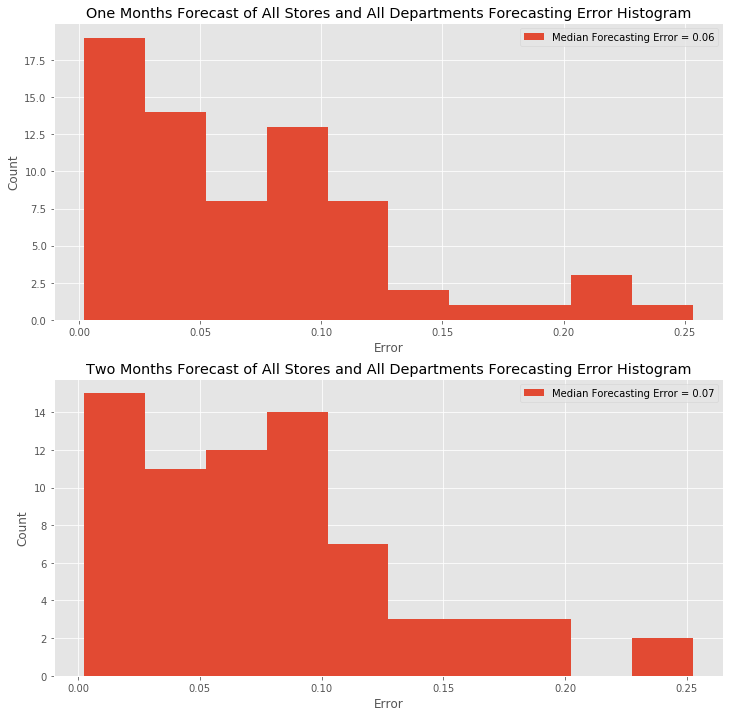

In [13]:
plot_all_errors(store_id, dept_id, art_dict, 'M')

In [16]:
art_dict = {}
art_dict[1] = resample_series(make_series('CA_1', 'HOBBIES_2'),'M')[44:]
art_dict[4] = resample_series(make_series('CA_1', 'FOODS_1'),'M')[22:]
art_dict[8] = resample_series(make_series('CA_2', 'HOBBIES_2'),'M')[38:]
art_dict[12] = resample_series(make_series('CA_2', 'FOODS_2'),'M')[-13:] #need to change when forecastin more than 6 periods, used to be [-6:]
art_dict[13] = resample_series(make_series('CA_2', 'FOODS_3'),'M')[53:]
art_dict[15] = resample_series(make_series('CA_3', 'HOBBIES_2'),'M')[38:]
art_dict[22] = resample_series(make_series('CA_4', 'HOBBIES_2'),'M')[38:]
art_dict[25] = resample_series(make_series('CA_4', 'FOODS_1'),'M')[16:]
#art_dict[29] = resample_series(make_series('TX_1', 'HOBBIES_2'),'M')[38:]
art_dict[30] = resample_series(make_series('TX_1', 'HOUSEHOLD_1'),'M')[16:]
art_dict[32] = resample_series(make_series('TX_1', 'FOODS_1'),'M')[14:]
art_dict[39] = resample_series(make_series('TX_2', 'FOODS_1'),'M')[46:]
art_dict[40] = resample_series(make_series('TX_2', 'FOODS_2'),'M')[26:]
art_dict[43] = resample_series(make_series('TX_3', 'HOBBIES_2'),'M')[46:]
art_dict[44] = resample_series(make_series('TX_3', 'HOUSEHOLD_1'),'M')[26:]
art_dict[46] = resample_series(make_series('TX_3', 'FOODS_1'),'M')[26:]
art_dict[50] = resample_series(make_series('WI_1', 'HOBBIES_2'),'M')[41:]
art_dict[57] = resample_series(make_series('WI_2', 'HOBBIES_2'),'M')[26:]
art_dict[60] = resample_series(make_series('WI_2', 'FOODS_1'),'M')[16:]
art_dict[66] = resample_series(make_series('WI_3', 'HOUSEHOLD_2'),'M')[40:]
art_dict[68] = resample_series(make_series('WI_3', 'FOODS_2'),'M')[34:]
art_dict[69] = resample_series(make_series('WI_3', 'FOODS_3'),'M')[26:]

In [21]:
def plot_all_errors6(store_ids, dept_ids, art_dict, interval):
    series_lst = []
    for idx, val in enumerate(series_setup(store_ids, dept_ids)):
        if idx not in art_dict.keys():
            series_lst.append(resample_series(make_series(val[0], val[1]), interval))
        else:
            series_lst.append(art_dict[idx])
            
    series_lst_no_adjustment = []
    for i in series_setup(store_ids, dept_ids):
            series_lst_no_adjustment.append(make_series(i[0], i[1]))

    forecast_lst = []
    for idx, val in enumerate(series_lst):
        if len(val) < 24:
            forecast_lst.append(abs(make_forecast_update(val, interval, 6, 1, 10, make_forecast1(series_lst_no_adjustment[idx], interval, 6, 1, 10)[3])[1]))
        else:
            forecast_lst.append(abs(make_forecast_update_w_sd(val, interval, 6, 1, 10)[1]))    
    arr = np.array(forecast_lst)
    
    forecast_lst1 = []
    for idx, val in enumerate(series_lst):
        if len(val) < 24:
            forecast_lst1.append(abs(make_forecast_update(val, interval, 6, 2, 11, make_forecast1(series_lst_no_adjustment[idx], interval, 6, 2, 11)[3])[1]))
        else:
            forecast_lst1.append(abs(make_forecast_update_w_sd(val, interval, 6, 2, 11)[1]))
    arr1 = np.array(forecast_lst1)
    
    forecast_lst2 = []
    for idx, val in enumerate(series_lst):
        if len(val) < 24:
            forecast_lst2.append(abs(make_forecast_update(val, interval, 6, 3, 12, make_forecast1(series_lst_no_adjustment[idx], interval, 6, 3, 12)[3])[1]))
        else:
            forecast_lst2.append(abs(make_forecast_update_w_sd(val, interval, 6, 3, 12)[1]))    
    arr2 = np.array(forecast_lst2)
    
    forecast_lst3 = []
    for idx, val in enumerate(series_lst):
        if len(val) < 24:
            forecast_lst3.append(abs(make_forecast_update(val, interval, 6, 4, 1, make_forecast1(series_lst_no_adjustment[idx], interval, 6, 4, 1)[3])[1]))
        else:
            forecast_lst3.append(abs(make_forecast_update_w_sd(val, interval, 6, 4, 1)[1]))
    arr3 = np.array(forecast_lst3)
    
    forecast_lst4 = []
    for idx, val in enumerate(series_lst):
        if len(val) < 24:
            forecast_lst4.append(abs(make_forecast_update(val, interval, 6, 5, 2, make_forecast1(series_lst_no_adjustment[idx], interval, 6, 5, 2)[3])[1]))
        else:
            forecast_lst4.append(abs(make_forecast_update_w_sd(val, interval, 6, 5, 2)[1]))    
    arr4 = np.array(forecast_lst4)
    
    forecast_lst5 = []
    for idx, val in enumerate(series_lst):
        if len(val) < 24:
            forecast_lst5.append(abs(make_forecast_update(val, interval, 6, 6, 3, make_forecast1(series_lst_no_adjustment[idx], interval, 6, 6, 3)[3])[1]))
        else:
            forecast_lst5.append(abs(make_forecast_update_w_sd(val, interval, 6, 6, 3)[1]))
    arr5 = np.array(forecast_lst5)
    

    fig, axs = plt.subplots(3, 2, figsize = (12,23))
    axs[0, 0].hist(arr, label = f'Median Forecasting Error = {round(np.median(arr),2)}')
    axs[0, 0].set_title('1 Month Forecast of All Stores and All \n Departments Forecasting Error Histogram')
    axs[0, 0].set_ylabel('Count')
    axs[0, 0].set_xlabel('Error')
    axs[0, 0].legend()
    
    axs[1, 0].hist(arr1, label = f'Median Forecasting Error = {round(np.median(arr1),2)}')
    axs[1, 0].set_title('2 Months Forecast of All Stores and All \n Departments Forecasting Error Histogram')
    axs[1, 0].set_ylabel('Count')
    axs[1, 0].set_xlabel('Error')
    axs[1, 0].legend()
    
    axs[2, 0].hist(arr2, label = f'Median Forecasting Error = {round(np.median(arr2),2)}')
    axs[2, 0].set_title('3 Months Forecast of All Stores and All \n Departments Forecasting Error Histogram')
    axs[2, 0].set_ylabel('Count')
    axs[2, 0].set_xlabel('Error')
    axs[2, 0].legend()
    
    axs[0, 1].hist(arr3, label = f'Median Forecasting Error = {round(np.median(arr3),2)}')
    axs[0, 1].set_title('4 Months Forecast of All Stores and All \n Departments Forecasting Error Histogram')
    axs[0, 1].set_ylabel('Count')
    axs[0, 1].set_xlabel('Error')
    axs[0, 1].legend()
    
    axs[1, 1].hist(arr4, label = f'Median Forecasting Error = {round(np.median(arr4),2)}')
    axs[1, 1].set_title('5 Months Forecast of All Stores and All \n Departments Forecasting Error Histogram')
    axs[1, 1].set_ylabel('Count')
    axs[1, 1].set_xlabel('Error')
    axs[1, 1].legend()
    
    axs[2, 1].hist(arr5, label = f'Median Forecasting Error = {round(np.median(arr5),2)}')
    axs[2, 1].set_title('6 Months Forecast of All Stores and All \n Departments Forecasting Error Histogram')
    axs[2, 1].set_ylabel('Count')
    axs[2, 1].set_xlabel('Error')
    axs[2, 1].legend()
    
    plt.show()

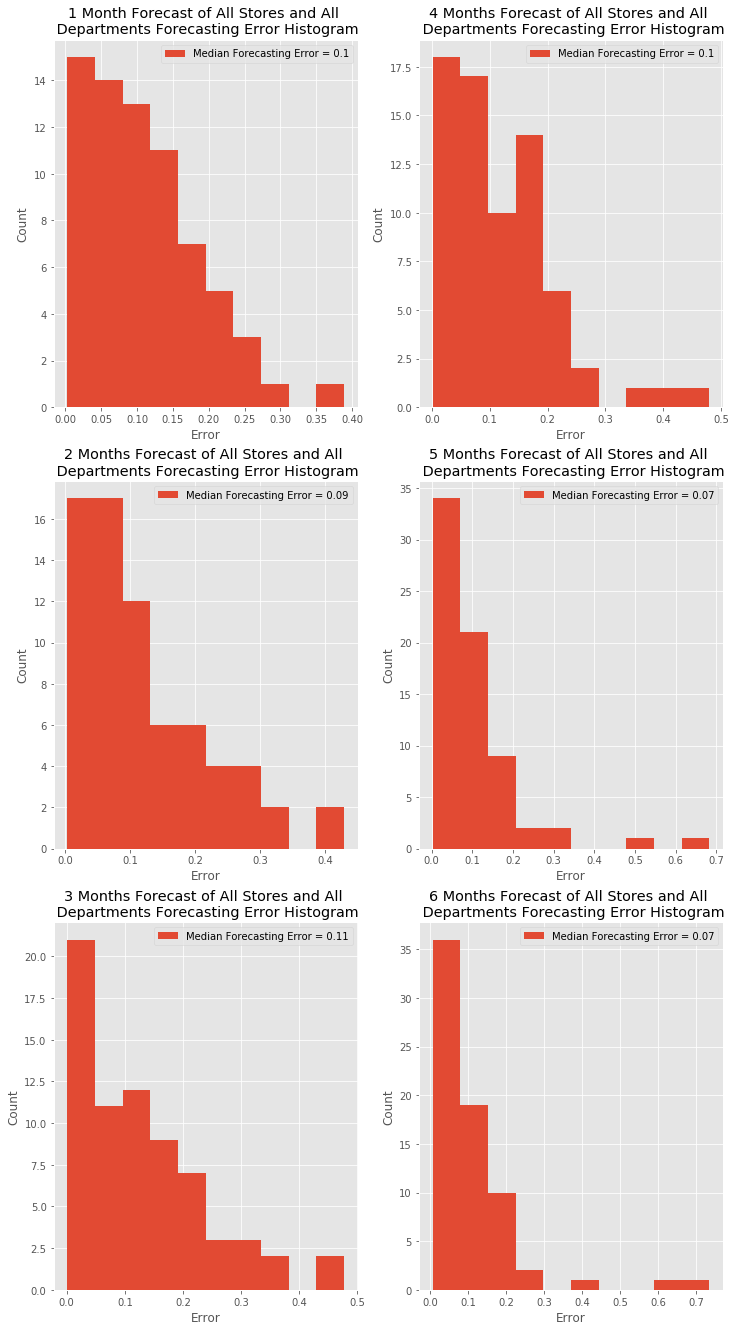

In [22]:
plot_all_errors6(store_id, dept_id, art_dict, 'M')

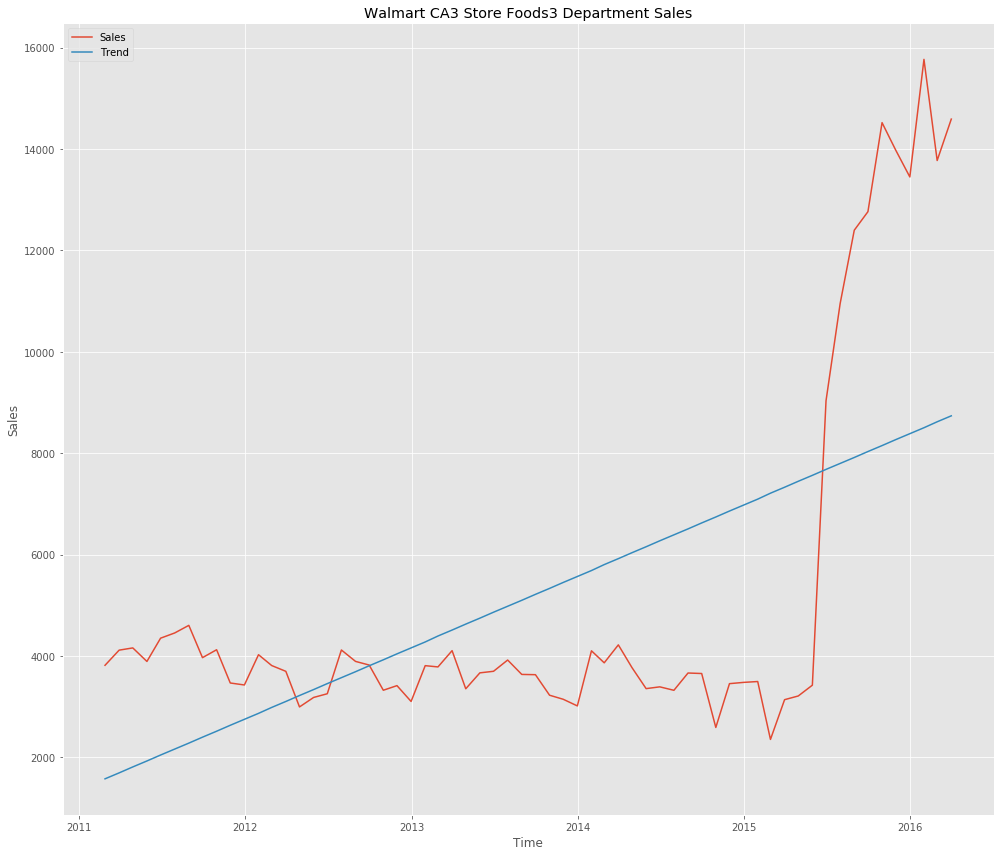

In [78]:
ca2_foods2 = Graphs(make_series('CA_2', 'FOODS_2'), 'M', 'Walmart CA3 Store Foods3 Department Sales')
ca2_foods2.linear_trend()

In [83]:
resample_series(make_series('CA_2', 'FOODS_2'),'M')[-6:]

,TOTAL
date,
2015-10-31,14520
2015-11-30,13978
2015-12-31,13449
2016-01-31,15768
2016-02-29,13773
2016-03-31,14590


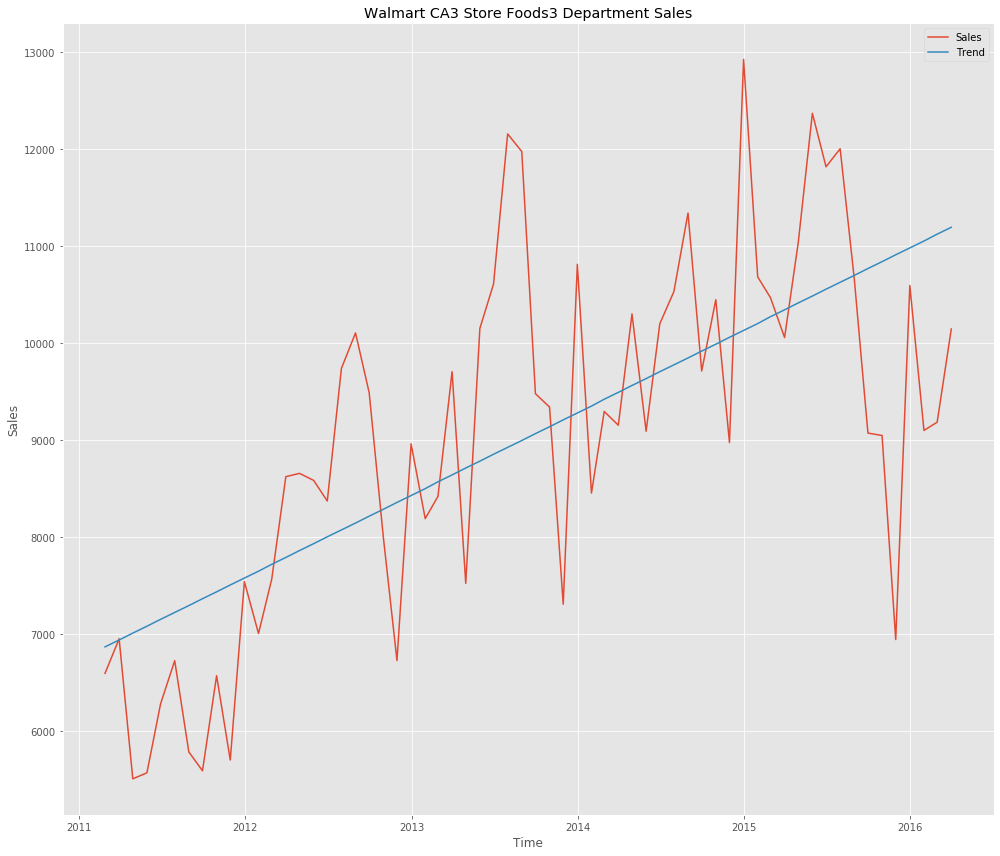

In [84]:
a = Graphs(make_series('CA_1', 'FOODS_1'), 'M', 'Walmart CA3 Store Foods3 Department Sales')
a.linear_trend()

In [89]:
resample_series(make_series('CA_1', 'FOODS_1'),'M')[22:]

,TOTAL
date,
2012-12-31,8963
2013-01-31,8191
2013-02-28,8421
2013-03-31,9708
2013-04-30,7524
...,...
2015-11-30,6944
2015-12-31,10596
2016-01-31,9101


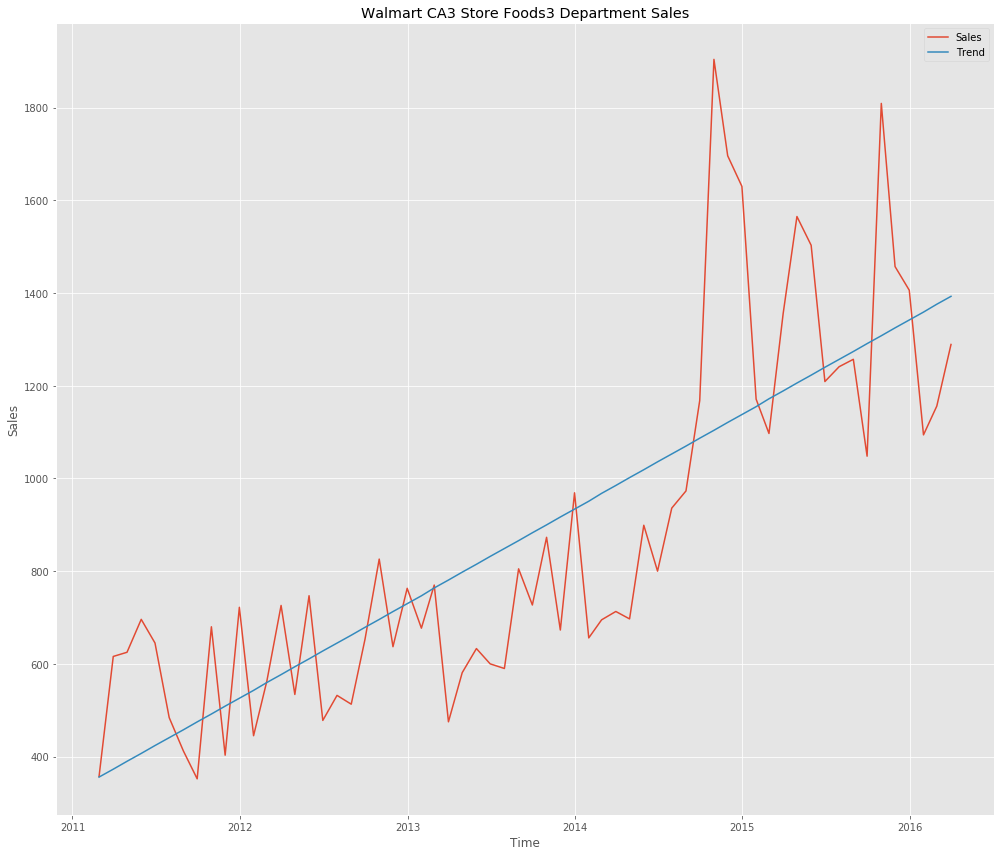

In [104]:
a = Graphs(make_series('CA_1', 'HOBBIES_2'), 'M', 'Walmart CA3 Store Foods3 Department Sales')
a.linear_trend()

In [109]:
resample_series(make_series('CA_1', 'HOBBIES_2'),'M')[44:]

,TOTAL
date,
2014-10-31,1904
2014-11-30,1696
2014-12-31,1630
2015-01-31,1171
2015-02-28,1097
...,...
2015-11-30,1457
2015-12-31,1406
2016-01-31,1094


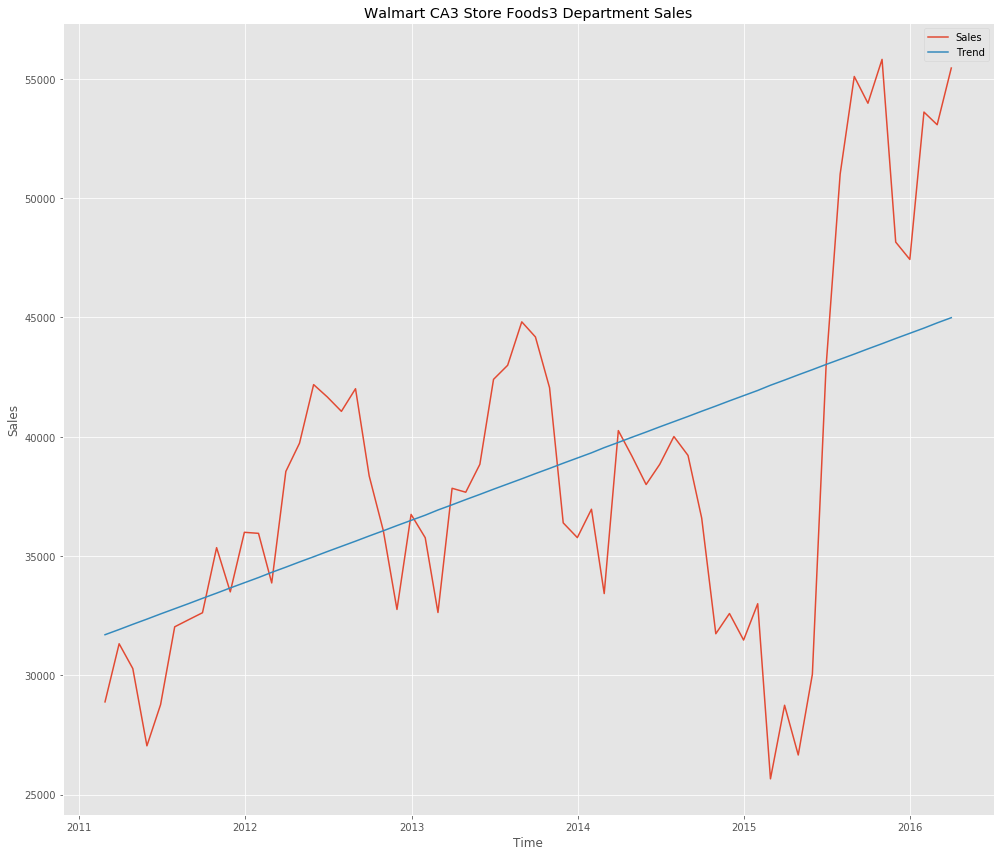

In [110]:
a = Graphs(make_series('CA_2', 'FOODS_3'), 'M', 'Walmart CA3 Store Foods3 Department Sales')
a.linear_trend()

In [113]:
resample_series(make_series('CA_2', 'FOODS_3'),'M')[53:]

,TOTAL
date,
2015-07-31,51008
2015-08-31,55101
2015-09-30,53980
2015-10-31,55818
2015-11-30,48158
2015-12-31,47432
2016-01-31,53609
2016-02-29,53078
2016-03-31,55455


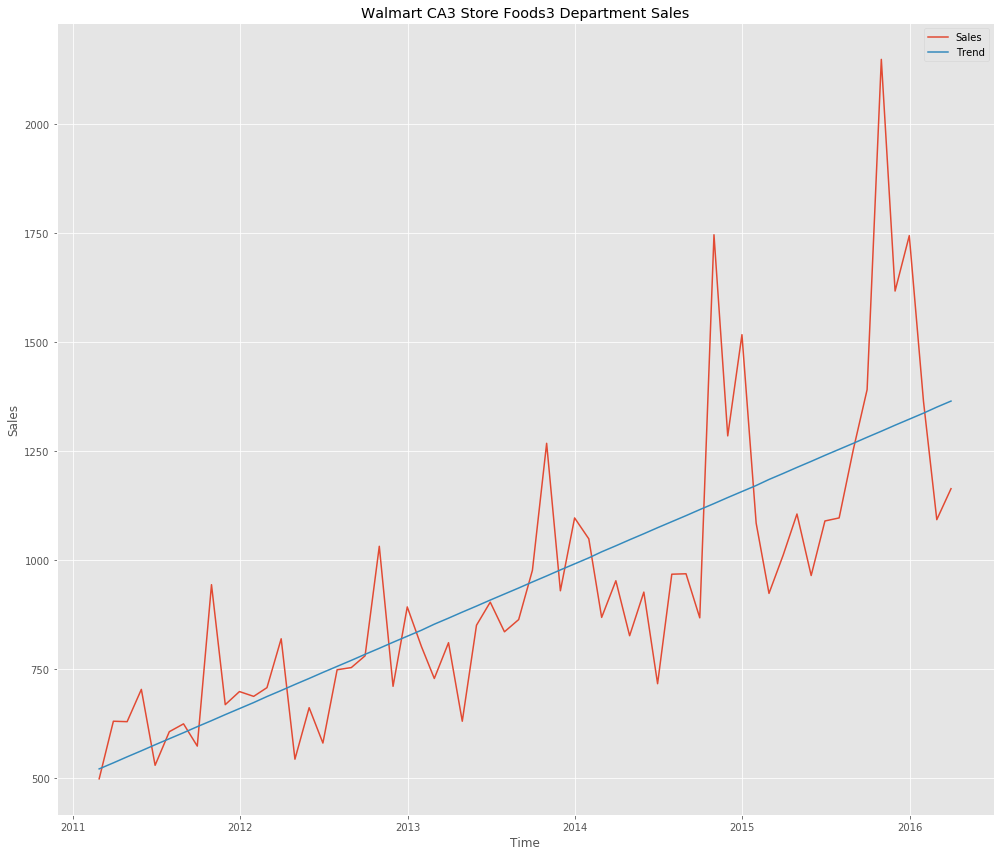

In [114]:
a = Graphs(make_series('CA_2', 'HOBBIES_2'), 'M', 'Walmart CA3 Store Foods3 Department Sales')
a.linear_trend()

In [25]:
len(resample_series(make_series('CA_2', 'HOBBIES_2'),'M')[38:])

24

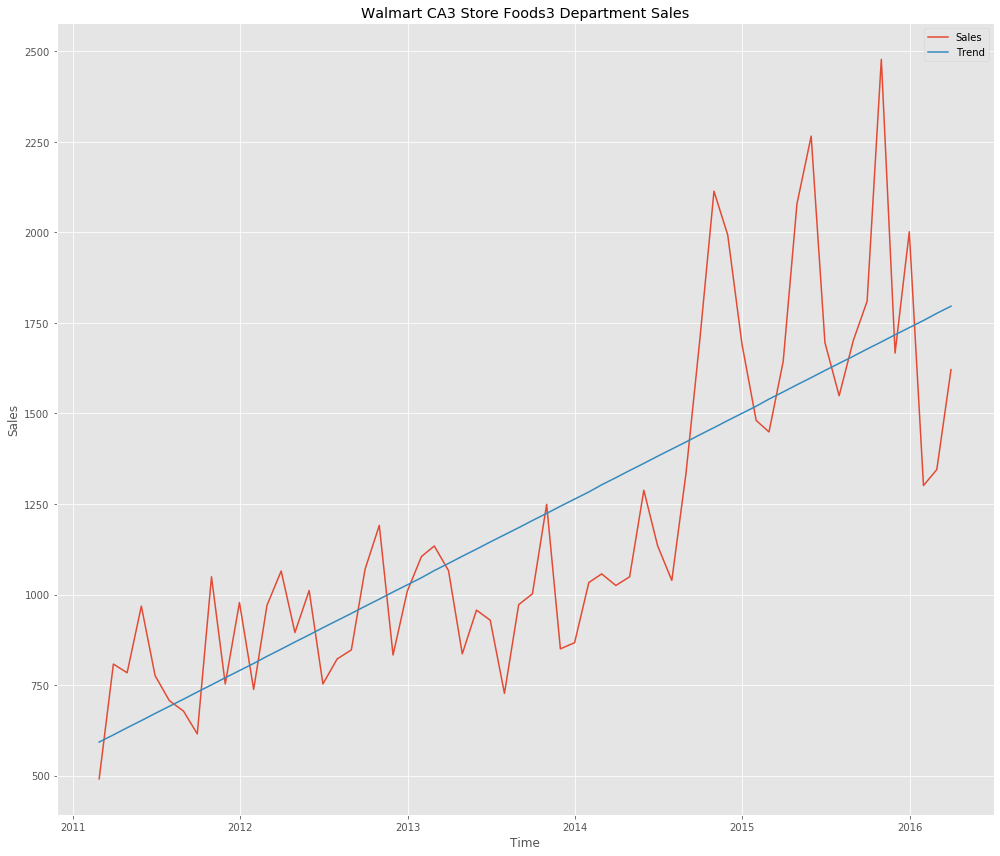

In [205]:
a = Graphs(make_series('CA_3', 'HOBBIES_2'), 'M', 'Walmart CA3 Store Foods3 Department Sales')
a.linear_trend()

In [207]:
resample_series(make_series('CA_3', 'HOBBIES_2'),'M')[43:]

,TOTAL
date,
2014-09-30,1702
2014-10-31,2114
2014-11-30,1993
2014-12-31,1692
2015-01-31,1481
...,...
2015-11-30,1667
2015-12-31,2002
2016-01-31,1301


,TOTAL
date,
2014-09-30,6105
2014-10-31,6674
2014-11-30,5115
2014-12-31,6532
2015-01-31,5929
2015-02-28,5742
2015-03-31,5838
2015-04-30,6304
2015-05-31,6284


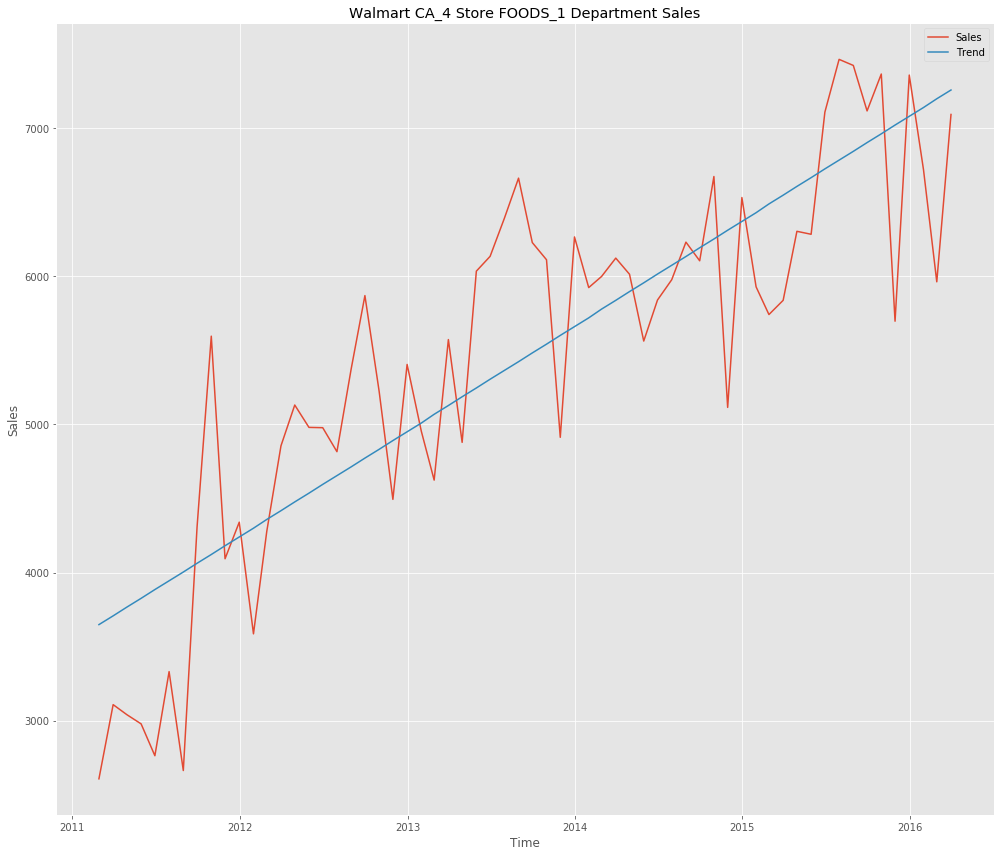

In [32]:
def update_series_forecast(store, department, periods):
    a = Graphs(make_series(store, department), 'M', f'Walmart {store} Store {department} Department Sales')
    a.linear_trend()
    return resample_series(make_series(store, department),'M')[periods:]

update_series_forecast('CA_4', 'FOODS_1', 43)

,TOTAL
date,
2012-04-30,6335
2012-05-31,6661
2012-06-30,6200
2012-07-31,6736
2012-08-31,6096
...,...
2015-11-30,5497
2015-12-31,6367
2016-01-31,8359


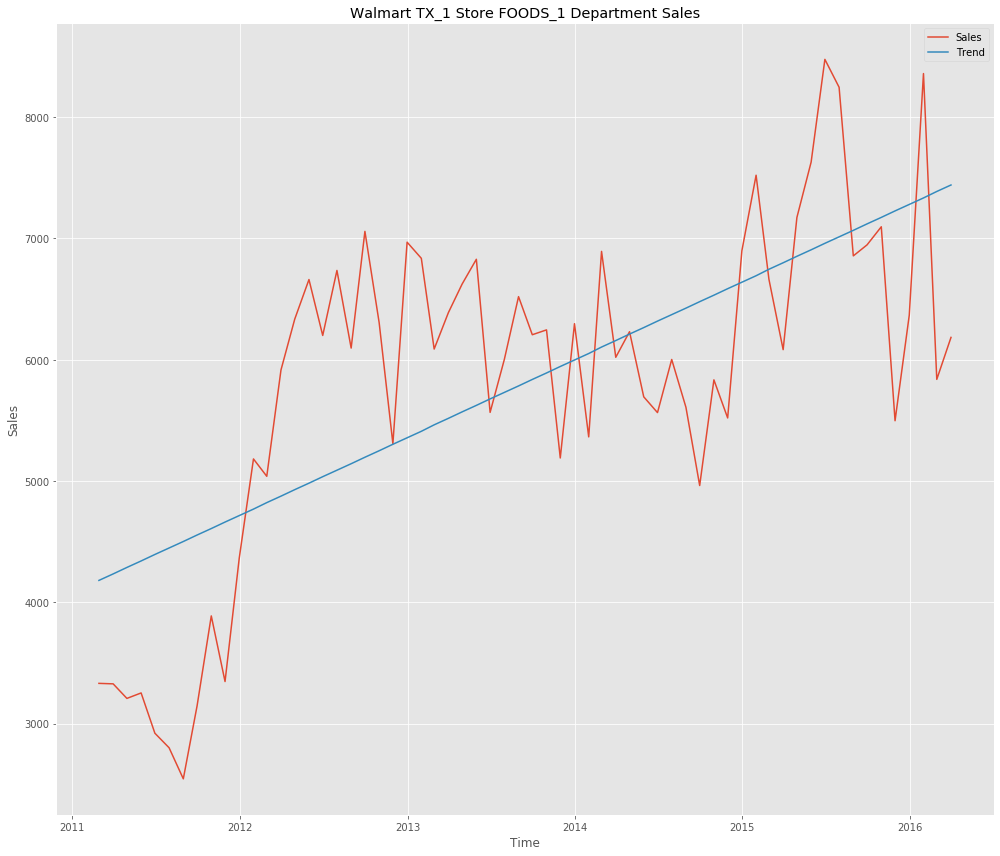

In [218]:
update_series_forecast('TX_1', 'FOODS_1', 14)

,TOTAL
date,
2014-12-31,8769
2015-01-31,8044
2015-02-28,7466
2015-03-31,7403
2015-04-30,8085
...,...
2015-11-30,6533
2015-12-31,7255
2016-01-31,7253


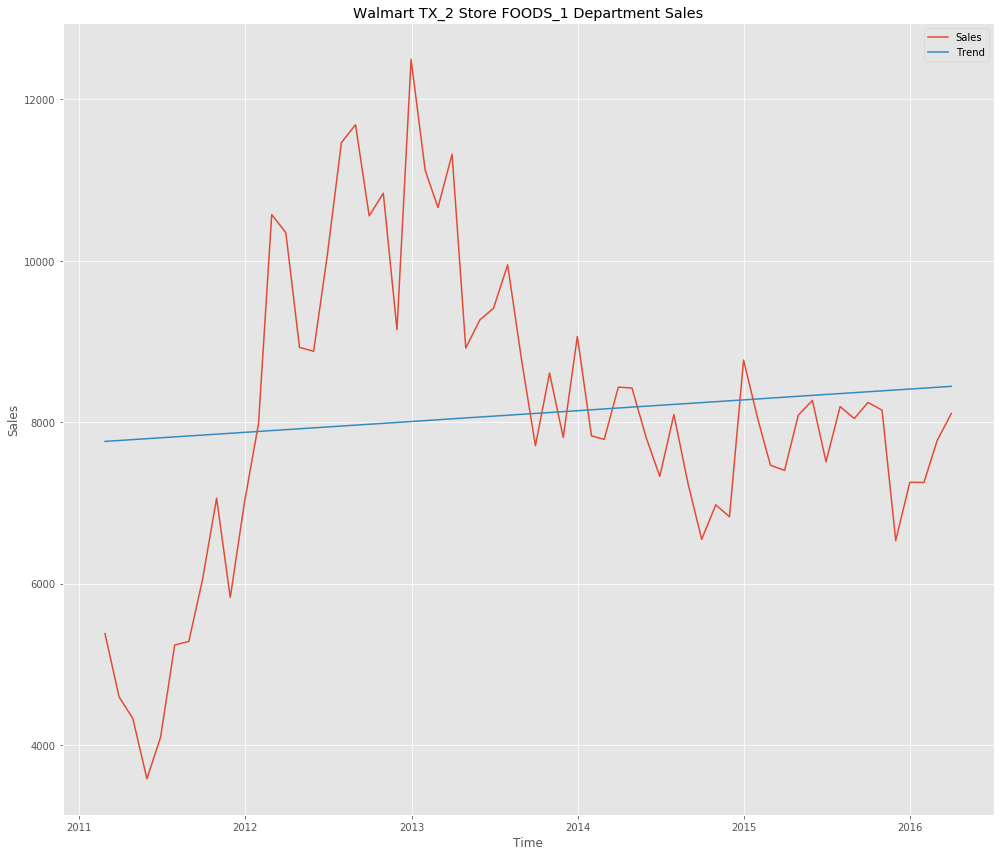

In [222]:
update_series_forecast('TX_2', 'FOODS_1', 46)

,TOTAL
date,
2014-09-30,1355
2014-10-31,2457
2014-11-30,1926
2014-12-31,1794
2015-01-31,1523
...,...
2015-11-30,1738
2015-12-31,1526
2016-01-31,1330


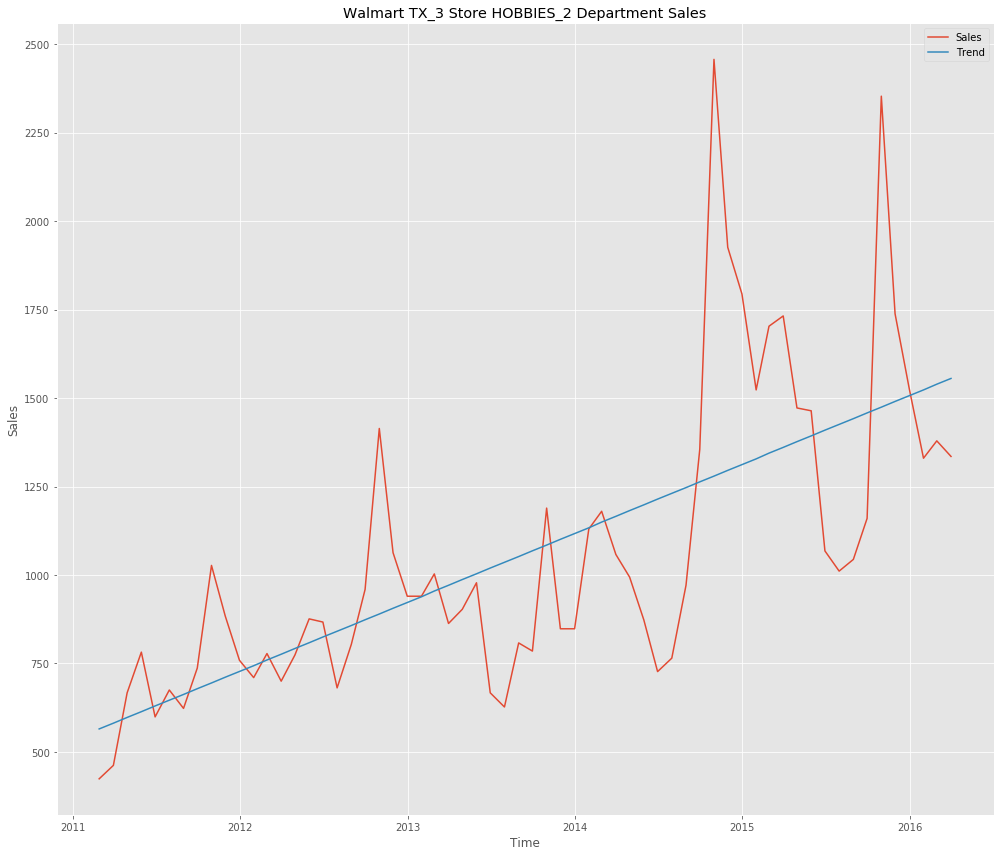

In [224]:
update_series_forecast('TX_3', 'HOBBIES_2', 43)

,TOTAL
date,
2014-07-31,780
2014-08-31,870
2014-09-30,983
2014-10-31,1865
2014-11-30,1597
...,...
2015-11-30,1166
2015-12-31,1480
2016-01-31,831


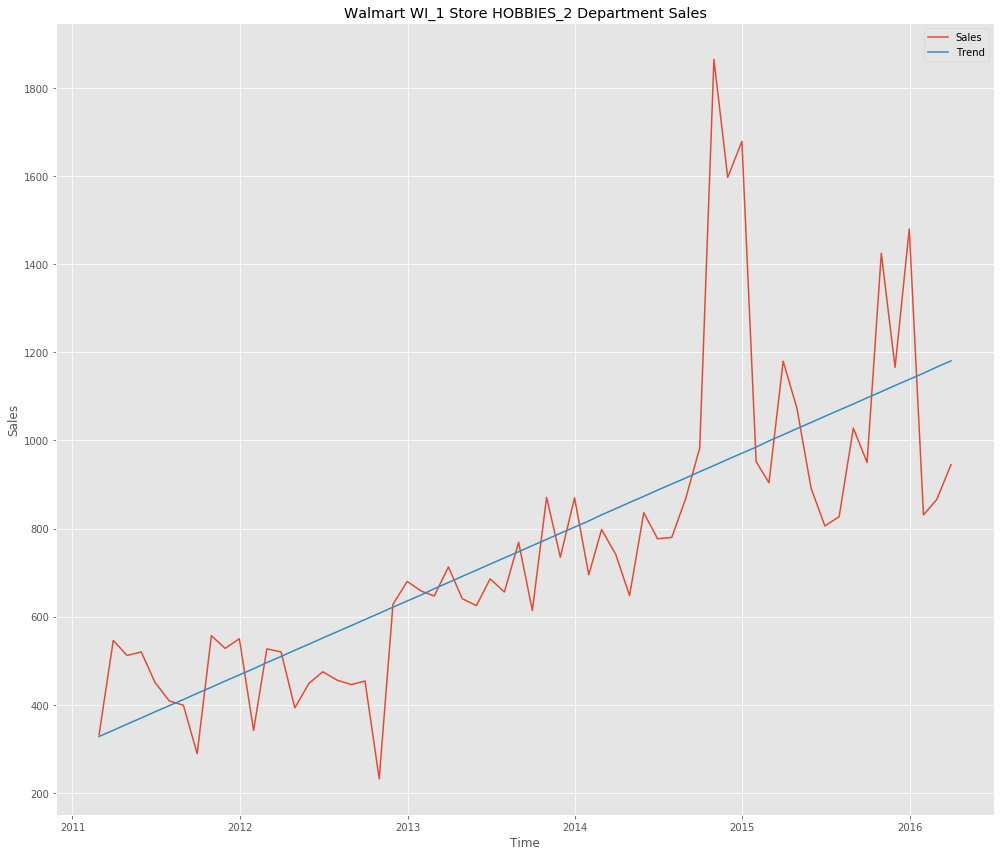

In [228]:
update_series_forecast('WI_1', 'HOBBIES_2', 41)

,TOTAL
date,
2012-06-30,7557
2012-07-31,8560
2012-08-31,10102
2012-09-30,10328
2012-10-31,9545
...,...
2015-11-30,8204
2015-12-31,9507
2016-01-31,10593


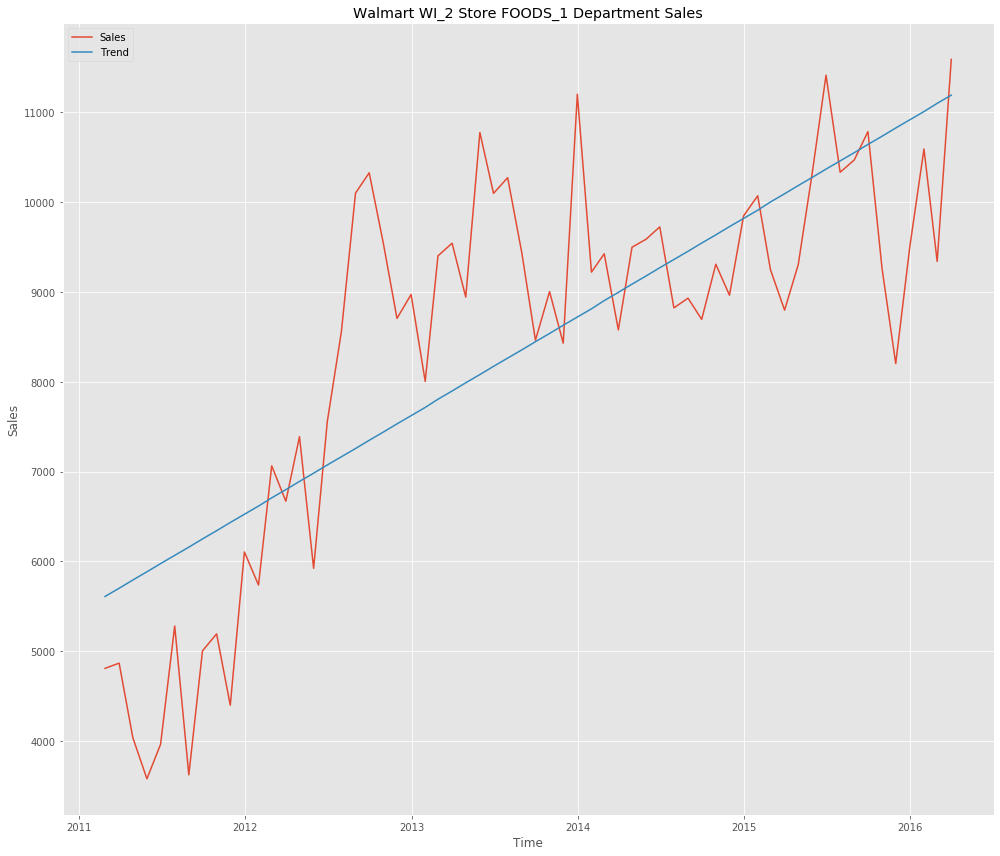

In [237]:
update_series_forecast('WI_2', 'FOODS_1', 16)

,TOTAL
date,
2012-06-30,12354
2012-07-31,14434
2012-08-31,14153
2012-09-30,14941
2012-10-31,13268
...,...
2015-11-30,14779
2015-12-31,14782
2016-01-31,16221


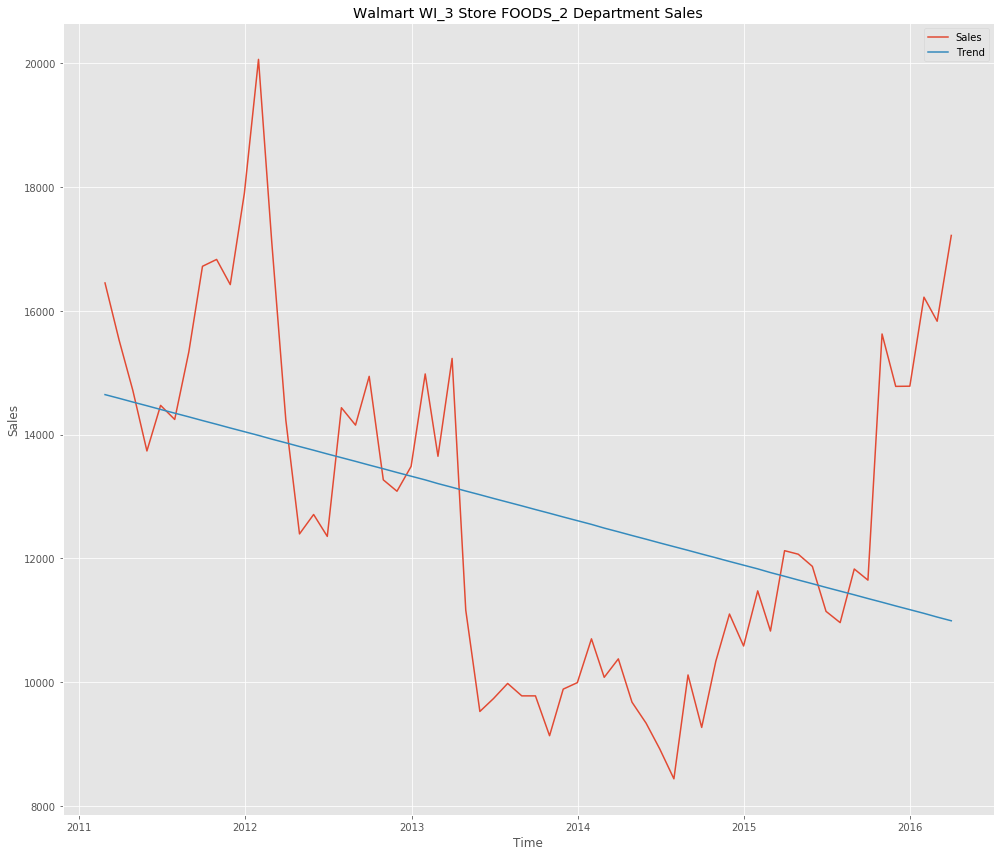

In [238]:
update_series_forecast('WI_3', 'FOODS_2', 16)

,TOTAL
date,
2014-06-30,3072
2014-07-31,2817
2014-08-31,3258
2014-09-30,2946
2014-10-31,3123
...,...
2015-11-30,3515
2015-12-31,3876
2016-01-31,4101


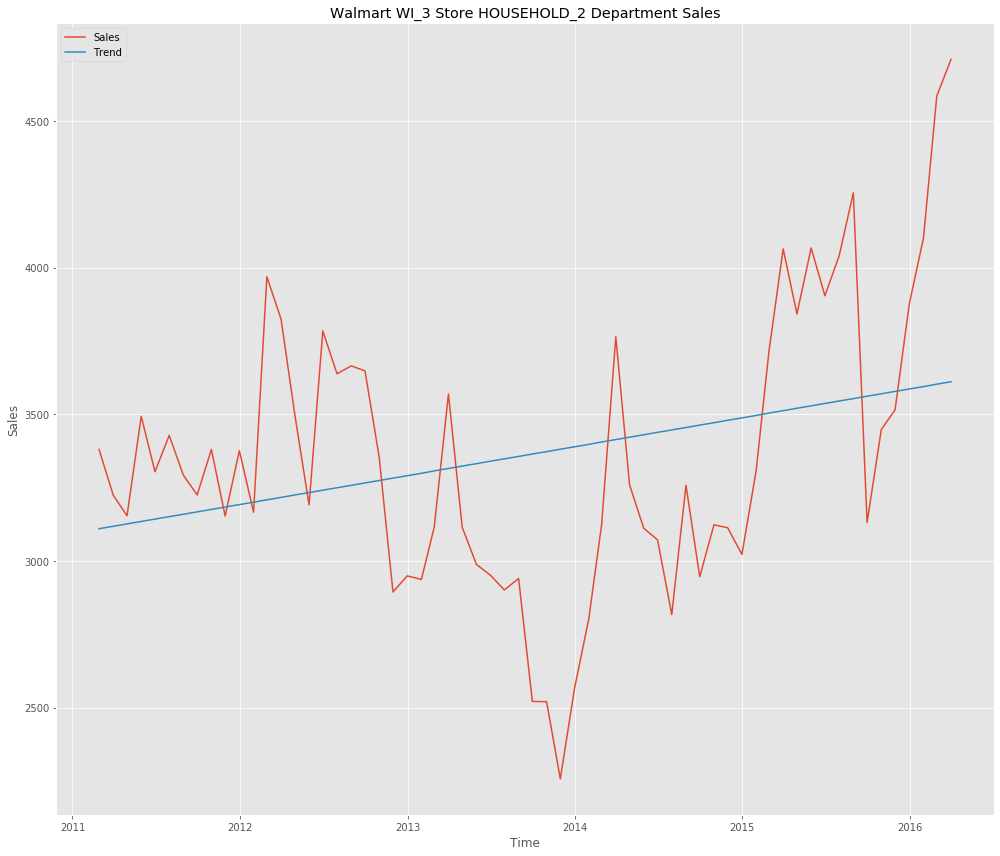

In [241]:
update_series_forecast('WI_3', 'HOUSEHOLD_2', 40)

24

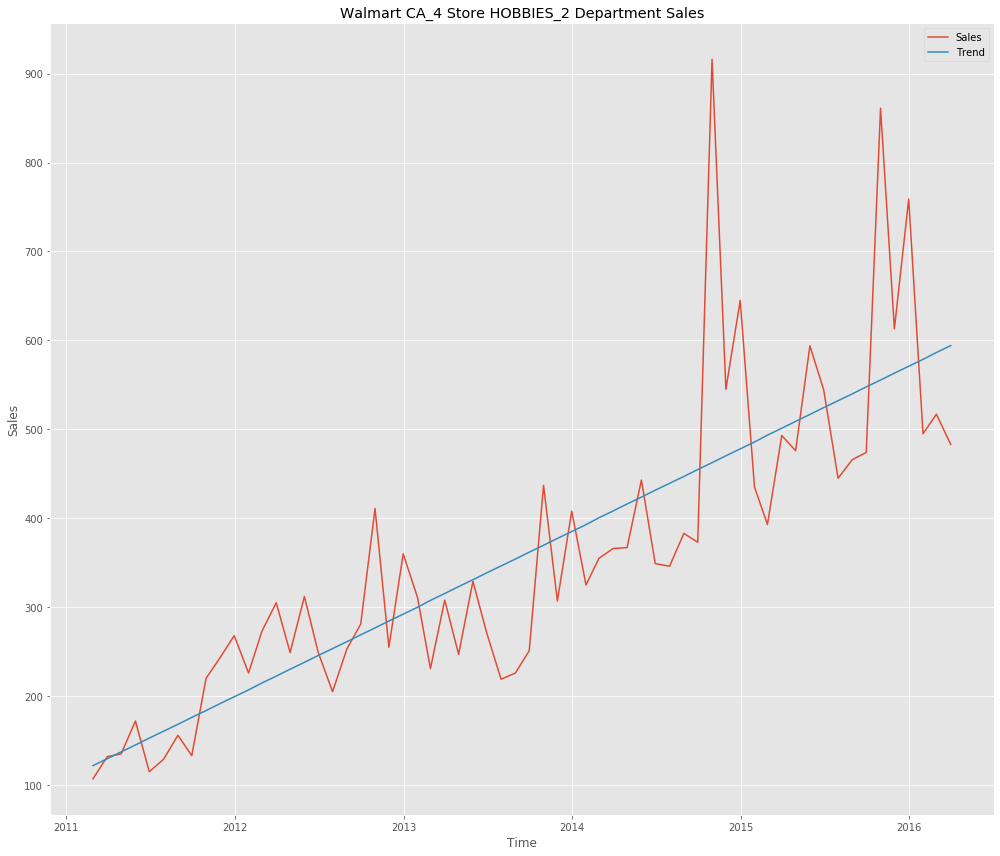

In [39]:
len(update_series_forecast('CA_4', 'HOBBIES_2', 38))

24

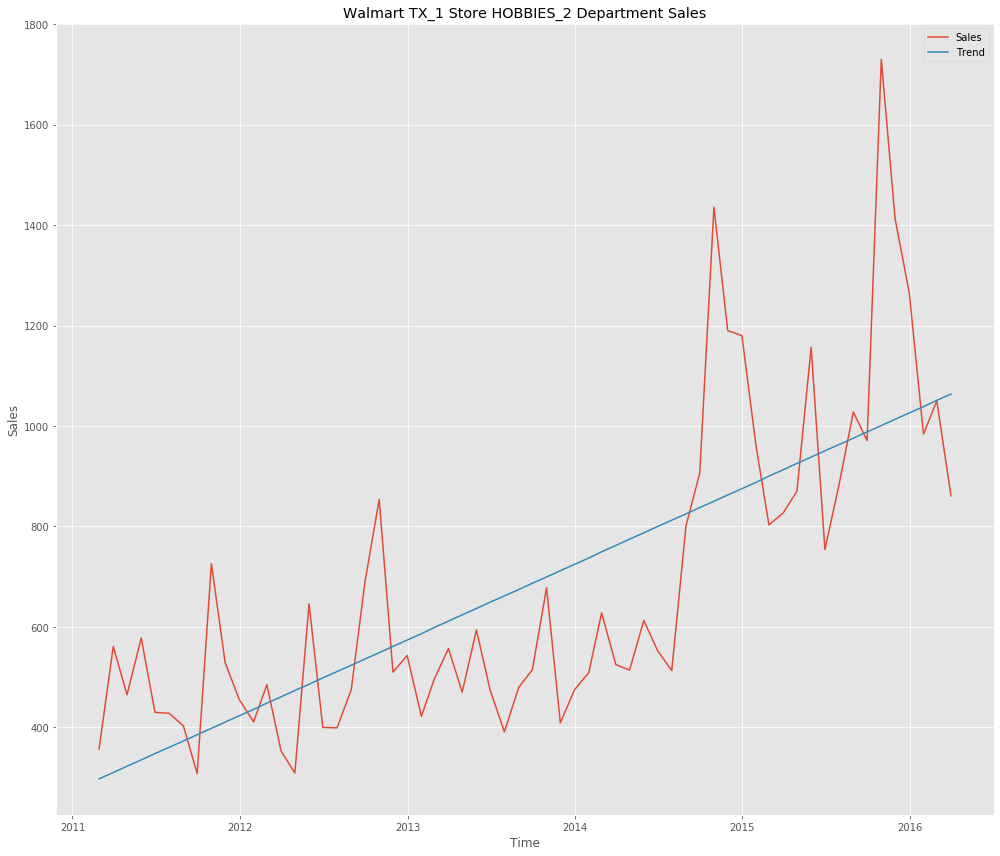

In [46]:
len(update_series_forecast('TX_1', 'HOBBIES_2', 38))

,TOTAL
date,
2012-06-30,17608
2012-07-31,16699
2012-08-31,18948
2012-09-30,22697
2012-10-31,19891
2012-11-30,18325
2012-12-31,20431
2013-01-31,18267
2013-02-28,21446


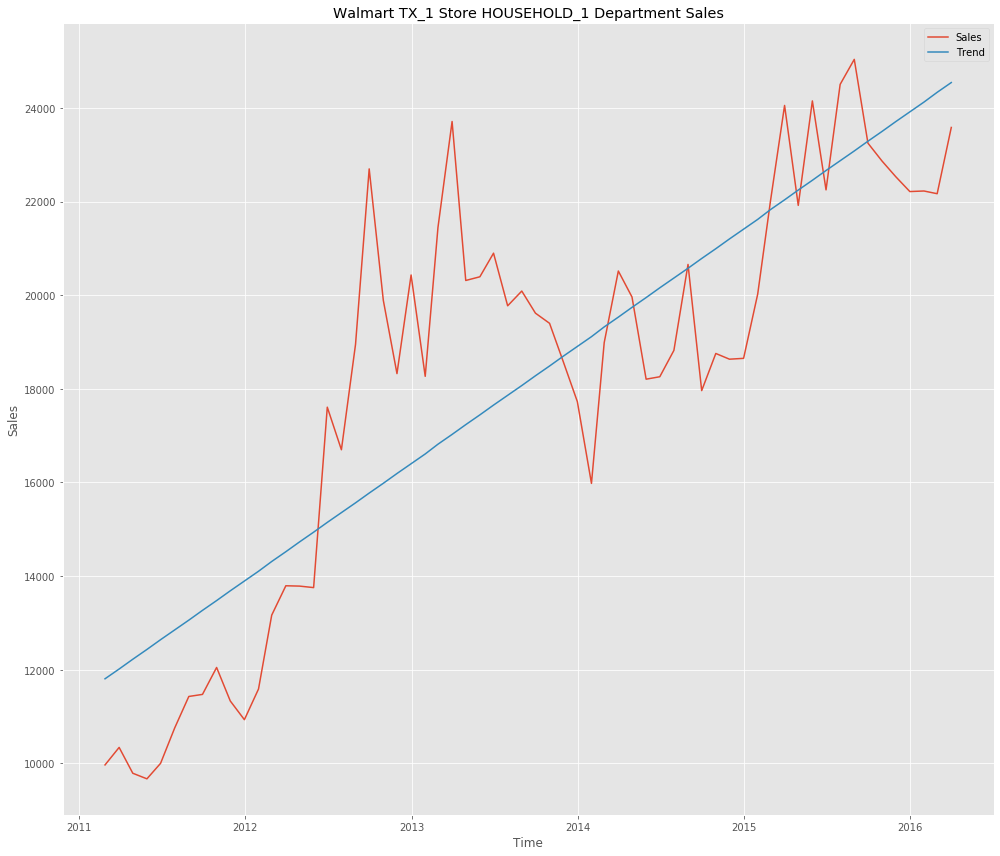

In [50]:
update_series_forecast('TX_1', 'HOUSEHOLD_1', 16)

,TOTAL
date,
2012-06-30,4782
2012-07-31,4720
2012-08-31,4827
2012-09-30,4605
2012-10-31,4594
2012-11-30,4023
2012-12-31,4437
2013-01-31,4218
2013-02-28,4804


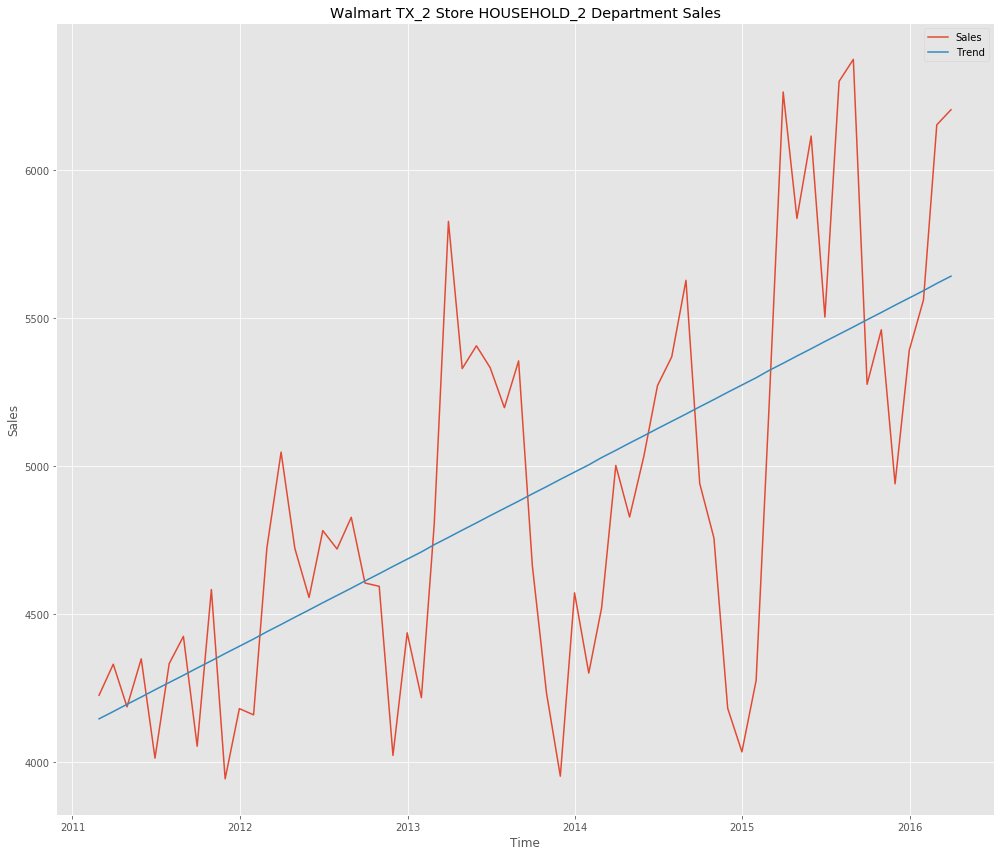

In [51]:
update_series_forecast('TX_2', 'HOUSEHOLD_2', 16)

,TOTAL
date,
2013-06-30,12890
2013-07-31,13280
2013-08-31,12620
2013-09-30,12196
2013-10-31,11825
2013-11-30,10029
2013-12-31,9444
2014-01-31,11133
2014-02-28,9985


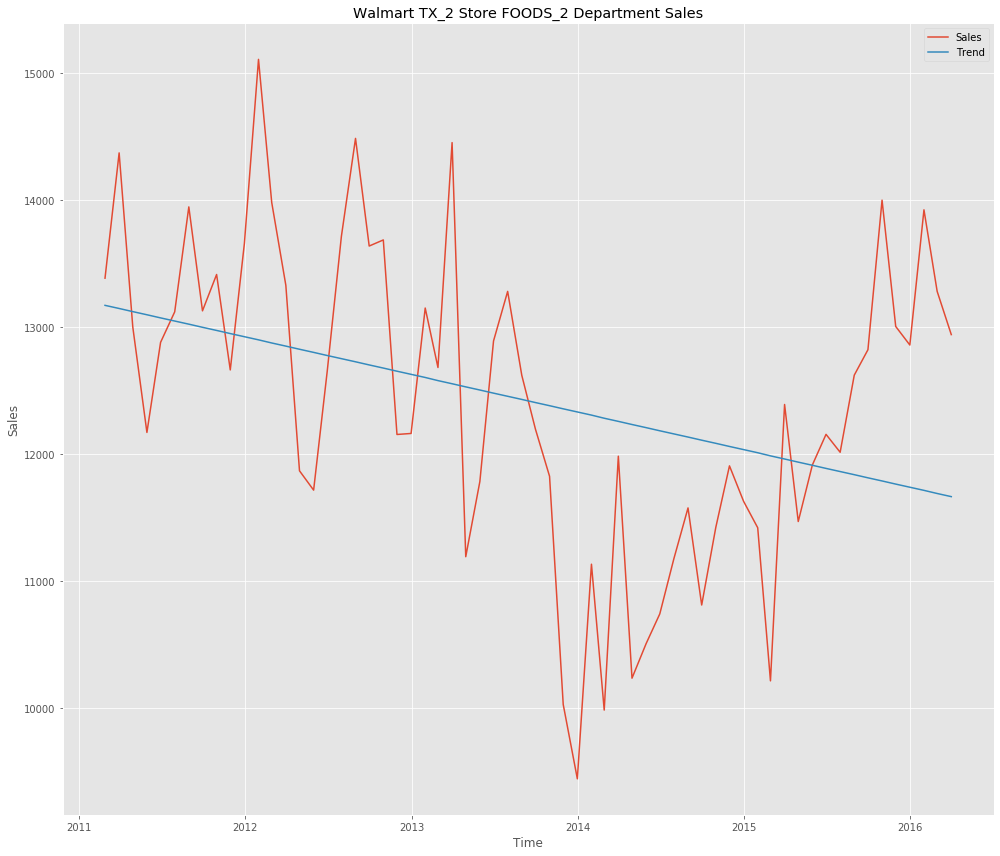

In [53]:
update_series_forecast('TX_2', 'FOODS_2', 28)

36

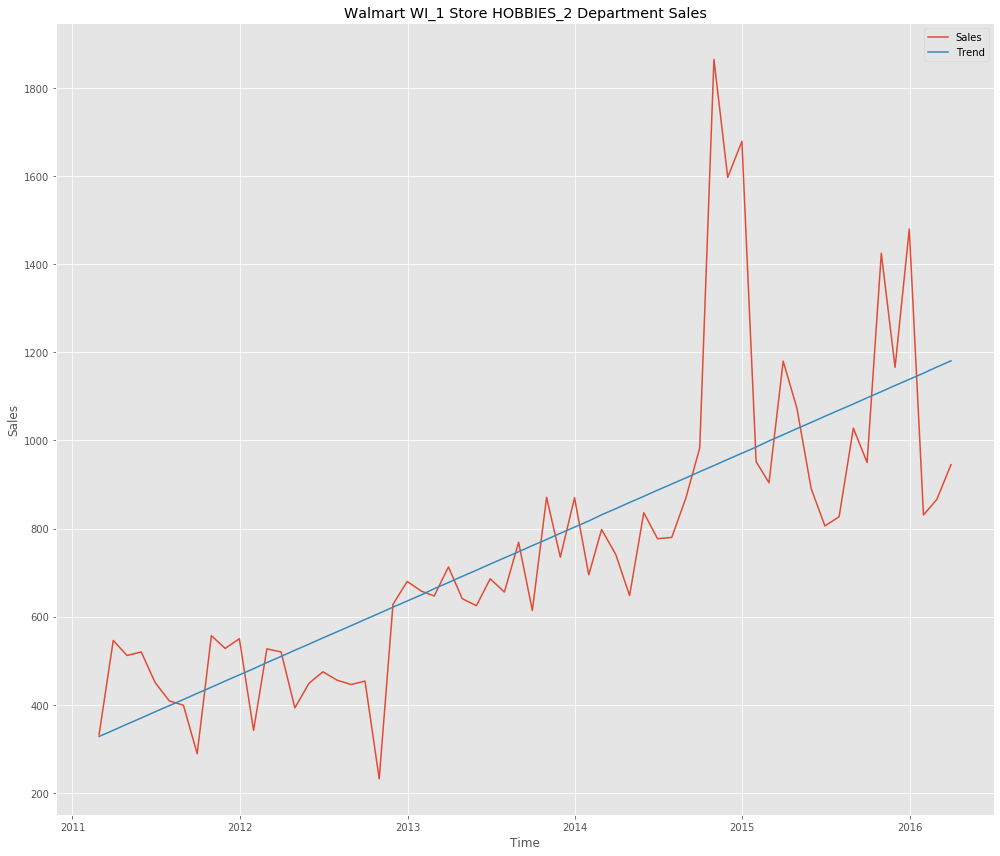

In [72]:
len(update_series_forecast('WI_1', 'HOBBIES_2', 26))